# MARQUER Matthieu
## Projet 4: Segmentez des clients d'un site e-commerce
 ![alt text](img/logo_olist_d7309b5f20.png "Olist")
 Partie 3


### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

### Modification des options

In [2]:
# https://pandas.pydata.org/docs/reference/api/pandas.set_option.html
# pd.set_option("display.max_rows", 200)
# pd.set_option("display.max_colwidth", 500)
pd.set_option('display.max_columns', 100)

### Importation des fichiers

In [3]:
# Import csv
data2 = pd.read_csv('data/cleaned/data2.csv') 

In [4]:
# Modification du type en: datetime64
data2["order_purchase_timestamp"] = pd.to_datetime(data2["order_purchase_timestamp"], format="%Y-%m-%d")

# Stabilité dans le temps

In [5]:
# Copie du DF avec choix des variables
data_stabilite = data2[["recence", "review_score", "montant", "temps_livraison", "order_purchase_timestamp"]]
data_stabilite

,recence,review_score,montant,temps_livraison,order_purchase_timestamp
0,331,4,38.71,8,2017-10-02 10:56:33
1,35,4,141.46,13,2018-07-24 20:41:37
2,21,5,179.12,9,2018-08-08 08:38:49
3,283,5,72.20,13,2017-11-18 19:28:06
4,196,5,28.62,2,2018-02-13 21:18:39
...,...,...,...,...,...
95555,538,5,85.08,8,2017-03-09 09:54:05
95556,204,4,195.00,22,2018-02-06 12:58:58
95557,367,5,271.01,24,2017-08-27 14:46:43
95558,232,2,220.58,17,2018-01-08 21:28:27


In [6]:
# Fonction qui ajoute 1 mois a une date et modifie l'année au besoin

import calendar

def un_mois_sup(base):

    new_year = base.year
    new_month = base.month + 1
    # Si sup a 12 change l'année
    if new_month > 12:
        new_year += 1
        new_month -= 12

    last_day_of_month = calendar.monthrange(new_year, new_month)[1]
    new_day = min(base.day, last_day_of_month)

    return base.replace(year=new_year, month=new_month, day=new_day)

In [7]:
# Creation des bases futures B0 à Bn 

import datetime
from dateutil.relativedelta import relativedelta

# Enregistrement de la premiere date d'achat global
date_min = data_stabilite.order_purchase_timestamp.min()

# 1 an par rapport à la 1ère date
date_annee_un = date_min + datetime.timedelta(days=365)

# Enregistrement de la derniere date d'achat global
date_max = data_stabilite.order_purchase_timestamp.max()

# Initialisation liste des DF
dataframes_list = []

# Différence entre date_max et date_annee_un
difference = relativedelta(date_max, date_annee_un)

# Nombre total de mois apres l'année (1)
nombre_de_mois = difference.years * 12 + difference.months + 1

# Boucle de creation des DataFrames
for suffix in range(nombre_de_mois):
    # Nom du DataFrame en fonction du suffixe
    nom_df = f"B{suffix}"
    
    # Création du DataFrame jusqu'à la derniere date
    current_df = data_stabilite.loc[data_stabilite["order_purchase_timestamp"] <= date_annee_un]
    
    # Ajout du DataFrame à la liste
    dataframes_list.append((nom_df, current_df))
    
    # Vérification
    print(f"{nom_df} créé avec {current_df.shape[0]} lignes.")
    
    # Maj de la date pour la prochaine itération
    date_annee_un = un_mois_sup(date_annee_un)

# Affichage des noms de DataFrames créés
for nom_df, df in dataframes_list:
    globals()[nom_df] = df

B0 créé avec 42190 lignes.
B1 créé avec 48388 lignes.
B2 créé avec 55318 lignes.
B3 créé avec 61992 lignes.
B4 créé avec 68728 lignes.
B5 créé avec 76061 lignes.
B6 créé avec 81699 lignes.
B7 créé avec 87329 lignes.
B8 créé avec 95207 lignes.


In [8]:
# Vérification des dates
for suffix in range(nombre_de_mois):
    nom_df = f"B{suffix}"
    current_df = globals()[nom_df]
    
    print(f"{nom_df}: {current_df.order_purchase_timestamp.min()} - {current_df.order_purchase_timestamp.max()}")

B0: 2016-12-23 23:16:47 - 2017-12-23 22:51:50
B1: 2016-12-23 23:16:47 - 2018-01-23 23:08:12
B2: 2016-12-23 23:16:47 - 2018-02-23 22:57:27
B3: 2016-12-23 23:16:47 - 2018-03-23 23:13:01
B4: 2016-12-23 23:16:47 - 2018-04-23 23:06:56
B5: 2016-12-23 23:16:47 - 2018-05-23 22:55:00
B6: 2016-12-23 23:16:47 - 2018-06-23 23:04:33
B7: 2016-12-23 23:16:47 - 2018-07-23 22:48:57
B8: 2016-12-23 23:16:47 - 2018-08-23 23:15:26


In [9]:
# Clustering C0 à Cn 

# Nombre de clusters
best_k = 4  ############################# nombre_clusters  = 4 ou best_k  #################################

# Initialisation de la liste des modèles
clustering_models = []

# Clustering pour B0
b0_data = B0[['recence', 'montant', 'review_score', 'temps_livraison']]
c0_cluster = KMeans(n_clusters=best_k, random_state=42)
c0_labels = c0_cluster.fit_predict(b0_data)
clustering_models.append(('C0', c0_cluster))

# Clustering pour les bases futures B1, B2, ... Bn
for suffix in range(nombre_de_mois): 
    nom_df = f"B{suffix}"
    current_data = globals()[nom_df][['recence', 'montant', 'review_score', 'temps_livraison']] 
    current_cluster = KMeans(n_clusters=best_k, random_state=42)
    current_labels = current_cluster.fit_predict(current_data)
    clustering_models.append((f'C{suffix}', current_cluster))

    # Affichage pour vérification
    print(f"C{suffix} créé avec {current_data.shape[0]} lignes.")

# Affichage des noms de modèles de clustering créés
for model_name, model in clustering_models:
    globals()[model_name] = model

C0 créé avec 42190 lignes.
C1 créé avec 48388 lignes.
C2 créé avec 55318 lignes.
C3 créé avec 61992 lignes.
C4 créé avec 68728 lignes.
C5 créé avec 76061 lignes.
C6 créé avec 81699 lignes.
C7 créé avec 87329 lignes.
C8 créé avec 95207 lignes.


In [10]:
# Segmenter B1, B2, ..., BN avec le modèle C0
for suffix in range(nombre_de_mois): 
    nom_df = f"B{suffix}"
    current_data = globals()[nom_df][['recence', 'montant', 'review_score', 'temps_livraison']]
    current_labels_c0 = c0_cluster.predict(current_data)
    globals()[f'{nom_df}_by_C0'] = current_labels_c0

    # Affichage pour vérification
    print(f"{nom_df}_by_C0 créé avec {len(current_labels_c0)} labels.")

B0_by_C0 créé avec 42190 labels.
B1_by_C0 créé avec 48388 labels.
B2_by_C0 créé avec 55318 labels.
B3_by_C0 créé avec 61992 labels.
B4_by_C0 créé avec 68728 labels.
B5_by_C0 créé avec 76061 labels.
B6_by_C0 créé avec 81699 labels.
B7_by_C0 créé avec 87329 labels.
B8_by_C0 créé avec 95207 labels.


In [11]:
# Segmentation B0 avec C0, B1 avec C1.... 
compteur = 0

# Liste pour stocker les noms de variables résultantes b1_by_c1, b2_by_c2, ..., bN_by_CN
result_variables = []

# Entraînement et segmentation de chaque modèle C1, C2, ..., CN
for suffix_c in range(nombre_de_mois):
    # Nom du modèle de clustering
    cluster_model_name = f"C{suffix_c}"
    
    # Création du modèle de clustering correspondant
    cluster_model = KMeans(n_clusters=best_k, random_state=42)
    clustering_models.append(cluster_model)
    
    # Entraînement du modèle avec le DataFrame correspondant
    nom_df = f"B{suffix_c}"
    current_data = globals()[nom_df][['recence', 'montant', 'review_score', 'temps_livraison']] 
    cluster_model.fit(current_data)
    
    # Segmentation de la base B avec le modèle de clustering correspondant
    current_labels_b = cluster_model.predict(current_data)
    result_variable_name = f"{nom_df}_by_{cluster_model_name}"
    globals()[result_variable_name] = current_labels_b
    result_variables.append(result_variable_name)
    compteur = compteur + 1

    # Affichage pour vérification
    print(f"{compteur}: {result_variable_name} créé avec {len(current_labels_b)} labels.")

1: B0_by_C0 créé avec 42190 labels.
2: B1_by_C1 créé avec 48388 labels.
3: B2_by_C2 créé avec 55318 labels.
4: B3_by_C3 créé avec 61992 labels.
5: B4_by_C4 créé avec 68728 labels.
6: B5_by_C5 créé avec 76061 labels.
7: B6_by_C6 créé avec 81699 labels.
8: B7_by_C7 créé avec 87329 labels.
9: B8_by_C8 créé avec 95207 labels.


In [12]:
# Comparaison de la segmentation entre C0 et les autres modèles
from sklearn.metrics import adjusted_rand_score

# Initialisation d'une liste pour stocker les résultats
rand_scores_list = []

# Comparaison de la segmentation entre C0 et les autres modèles
for suffix in range(nombre_de_mois):
    nom_df_c0 = f"B{suffix}_by_C0"
    nom_df_cx = f"B{suffix}_by_C{suffix}"
    
    labels_c0 = globals()[nom_df_c0]
    labels_cx = globals()[nom_df_cx]
    
    rand_score = adjusted_rand_score(labels_c0, labels_cx)
    rand_scores_list.append([f"B{suffix}", rand_score])

# Création du DataFrame "rand_scores_df"
rand_scores_df = pd.DataFrame(rand_scores_list, columns=['B', 'Rand Score'])
rand_scores_df

,B,Rand Score
0,B0,1.000000
1,B1,0.829475
2,B2,0.739717
3,B3,0.672210
4,B4,0.630230
5,B5,0.585344
6,B6,0.556321
7,B7,0.543285
8,B8,0.353132


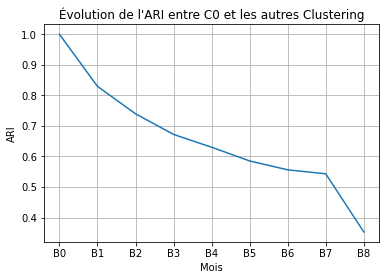

In [13]:
# Graphique de l'evolution de l'indice de rand
plt.plot(rand_scores_df.B, rand_scores_df["Rand Score"])
plt.title("Évolution de l'ARI entre C0 et les autres Clustering")
plt.xlabel('Mois')
plt.ylabel('ARI')
plt.grid(True)
plt.show()